Each task that is proposed to be completed as part of the homework has a declared "price" in points. The maximum possible amount is 10 points, and together with the bonus assignment - 12 points. It is not necessary to complete all the tasks, only a part can be done. Most of the points expect you to write working Python code; sometimes you will need to write comments - for example, to compare several approaches to solve the same problem. Also you can add more cells for your convenience if you need.

This homework focuses on clustering. We will work with images of handwritten digits, learn how to cluster them using two different methods (hierarchical clustering and the 𝐾-means algorithm), evaluate the quality of the partition and choose the optimal number of clusters, as well as visualize intermediate results.

## 1. Loading data
The data we will be working with is available in the scikit-learn library (`sklearn` module) in the `datasets` submodule via the `load_digits` function. The data contains 1,797 observations, each of which is 8×8 pixel image of a handwritten digit from 0 to 9. This is about the same amount of each digit (about 180).

For convenience, every image expands to a 64 (8×8) row, so entire numpy array is 1797×64. The color intensity in each pixel is encoded with an integer from 0 to 16.

In addition to images, their labels are also known. In this task, we will assume that the labels (as well as their amount) are unknown and try to group the data in such a way that the resulting clusters 'better match' the original ones. Possible options for determining the 'better match' are presented later.

**(0.25 points)** Load the images into `X` variable, and their labels into `y` variable.

In [1]:
from sklearn import datasets
X, y = datasets.load_digits(return_X_y=True)

In [2]:
assert X.shape == (1797, 64)
assert y.shape == (1797,)

**(0.5 points)** Visualize the first 10 images.

- Arrange images on a grid rather than in a row. You may need the `subplot` and `imshow` functions from the `pyplot` module in the `matplotlib` library.
- You will also need to reshape the images to 8×8.
- Remove ticks and labels from both axes. The `xticks` and `yticks` functions or the `tick_params` function from `pyplot` can help you with this.
- Make the output good sized with the `figure` function from `pyplot`.

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random as rd
sns.set(style='white')

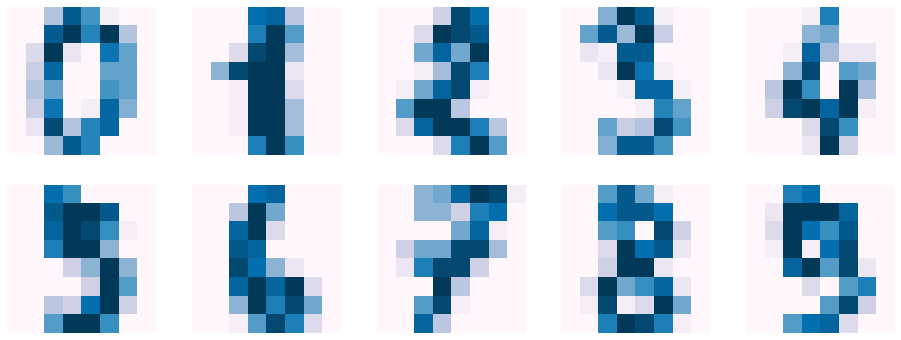

In [4]:
plt.figure(figsize=(16, 6))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    ax.set_axis_off()
    ax.imshow(X[i,:].reshape([8,8]), cmap='PuBu');

## 2. Clustering and quality evaluation

**(2 points)** Implement the the KMeans algorithm. Use objective function $L = \sum_{i=1}^{n}|x_{i}-Z_{A(x_{i})}|^{2}$, where $Z_{A(x_{i})}$ is the center of the cluster corresponding to $x_{i}$ object.

In [5]:
from sklearn.exceptions import NotFittedError
from numpy.random import RandomState

In [6]:
class CustomKMeans:
    def __init__(self, n_clusters=2, max_iter=30, n_init=10, random_state=42):
        '''K-Means clustering.
        
        Args:
            n_clusters: int, default=2
                The number of clusters to be formed is also 
                the number of centroids to generate. 
            max_iter: int, default=300
                Maximum number of iterations of the k-means algorithm for a
                single run.
            n_init: int, default=10
                Number of time the k-means algorithm will be run with different
                centroid seeds. The final results will be the best output of
                n_init consecutive runs in terms of objective function.
            random_state: int, default=42
                Random state.
        '''
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.random_state = RandomState(seed=random_state)
        
    def calculate_distances_to_centroids(self, X, cluster_centers):
        """
        Returns (n, c) matrix where the element at position (i, j) 
        is the distance from i-th object to j-th centroid."""
        
        return np.sum((X - cluster_centers[:, np.newaxis]) ** 2, axis=2).T
    
    def update_centroids(self, X, nearest_clusters):
        """
        Returns numpy array of shape (n_clusters, n_features) - 
        new clusters that are found by averaging objects belonging 
        to the corresponding cluster."""
        
        col_names = list(range(X.shape[1]))
        col_names.append('cluster')
        data = pd.DataFrame(np.c_[X, nearest_clusters.T], columns = col_names).groupby('cluster').agg('mean')
        return np.array(data.values)
        
    def fit(self, X):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        """
        assert X.shape[0] >= self.n_clusters
        if not(hasattr(self, 'cluster_centers_')):
            self.cluster_centers_ = np.zeros((self.n_clusters, X.shape[1]))
        
        if self.n_init > 0:
            
            r = []
            for k in range(self.n_clusters):
                i_r = self.random_state.randint(X.shape[0]-1)
                while i_r in r:
                    i_r = self.random_state.randint(X.shape[0]-1)
                r.append(i_r)
                self.cluster_centers_[k] = X[i_r]
            
            for i in range(self.max_iter):
                dist = self.calculate_distances_to_centroids(X, self.cluster_centers_)
                self.cluster_centers_ = self.update_centroids(X, np.argmin(dist, axis=1))
            
            #For each init saving each cluster_centers
            if not(hasattr(self, 'cluster_centers_dict')):
                self.cluster_centers_dict = dict()
            self.cluster_centers_dict[self.n_init] = self.cluster_centers_
            
            #For each init saving information about the least distance of each point
            #to the center of nearest cluster
            if not(hasattr(self, 'obj_func_dict')):
                self.obj_func_dict = dict()
            self.obj_func_dict[self.n_init] = np.mean(np.min(dist, axis =1))
            
            self.n_init -= 1
            
            #Finding best cluster centers by find a min mean in objective function
            if self.n_init == 0:
                best_init = min(self.obj_func_dict, key=self.obj_func_dict.get)
                self.cluster_centers_ = self.cluster_centers_dict[best_init]
                self.obj_func = self.obj_func_dict[best_init]
                
            return self.fit(X)
            
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted cluster labels.
        """
        if hasattr(self, 'cluster_centers_'):
            return np.argmin(self.calculate_distances_to_centroids(X, self.cluster_centers_), axis = 1)
        else: 
            raise NotFittedError("CustomKMeans instance is not fitted yet")

**(1 points)** Get the `X` array partition into 10 clusters. Visualize the centers of clusters.
- We will assume that the center of the cluster is average value of all observations belonging to the cluster.
- The cluster centers should have the same shape as our observations (64). So you have to average the points across the rows.

In [7]:
km = CustomKMeans(n_clusters=10)
km.fit(X)
custom_kmeans_labels = km.predict(X)
assert custom_kmeans_labels.shape == (1797,)

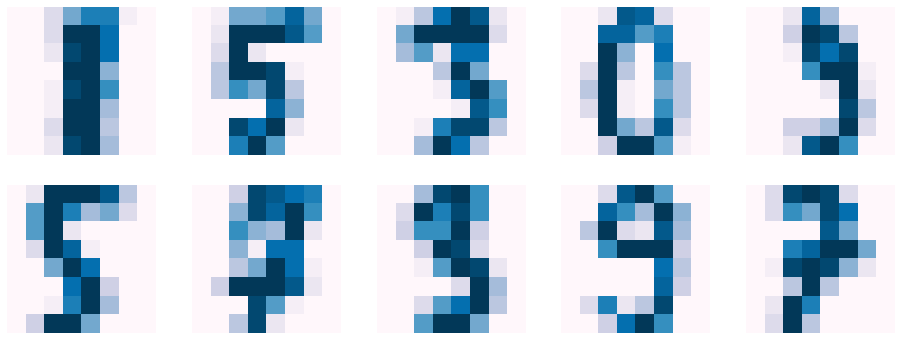

In [8]:
plt.figure(figsize=(16, 6))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    ax.set_axis_off()
    ax.imshow(km.cluster_centers_[i].reshape([8,8]), cmap='PuBu');

Some digits we can recognize without trouble, but some are not so clearly viewed.

**(0.5 points)** Experiment with `max_iter` and `n_init` parameters. Look at the range of values of the objective function, it's best values, at what parameters and how often they are achieved.

In [9]:
iterations = [5, 30, 50, 100, 200, 300, 400, 500]
obj_func = np.array([])

for it in iterations:
    model = CustomKMeans(n_clusters=10, max_iter=it)
    model.fit(X) 
    obj_func = np.append(obj_func, model.obj_func)  

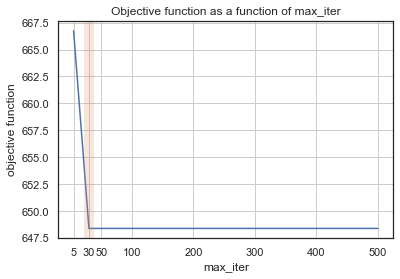

In [10]:
plt.plot(iterations, obj_func)
plt.axvline(iterations[np.argmin(obj_func)], color='C1', lw=10, alpha=0.2)
plt.grid(True)
plt.title("Objective function as a function of max_iter")
plt.xticks(iterations)
plt.xlabel('max_iter')
plt.ylabel('objective function');

In [11]:
print(f'Range of objective function values: {np.min(obj_func)} --- {np.max(obj_func)}')
print(f'Best objective function value: {np.min(obj_func)}')

Range of objective function values: 648.3970390562674 --- 666.7460268769466
Best objective function value: 648.3970390562674


In [12]:
initializations = [1, 2, 5, 10, 20, 30, 50]
obj_f_values = []

for i in initializations:
    model = CustomKMeans(n_clusters=10, n_init=i)
    model.fit(X)
    obj_f_values.append(model.obj_func)

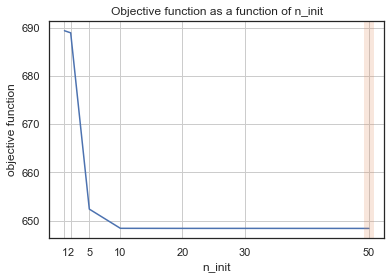

In [13]:
plt.plot(initializations, obj_f_values)
plt.axvline(initializations[np.argmin(obj_f_values)], color='C1', lw=10, alpha=0.2)
plt.grid(True)
plt.title("Objective function as a function of n_init")
plt.xticks(initializations)
plt.xlabel('n_init')
plt.ylabel('objective function');

In [14]:
print(f'Range of objective function values: {np.min(obj_f_values)} --- {np.max(obj_f_values)}')
print(f'Best objective function value: {np.min(obj_f_values)}')

Range of objective function values: 648.3774166431238 --- 689.3414469450399
Best objective function value: 648.3774166431238


We can see that there are optimal values of max_iter and n_init. With increasing it further the objective function doesn't change a lot.

Also, small values of max_iter and n_init (smaller optimal values which are highlighted with vertical lines on plot) are not enough for getting the best result.

Now we will use two popular algorithms: hierarchical clustering and $K$-means clustering. These and other algorithms are available in the `scikit-learn` module in the `cluster` submodule. Hierarchical clustering is called `AgglomerativeClustering`, and the $K$-means method is called `KMeans`.

**(0.5 points)** Use each of the two methods: hierarchical clustering and KMeans. Get the `X` array partition into 10 clusters.

- Note that `AgglomerativeClustering` does not have a `predict` method, so you can either use the `fit_predict` method or use the `fit` method and then look at the `labels_` attribute of the class instance.
- Kmeans performs multiple runs (default 10) with random centers and then returns the best partition in terms of average distance within the clusters. You can increase the number of runs to improve the quality of predictions in the `i_init` parameter.

In [15]:
from sklearn.cluster import AgglomerativeClustering, KMeans

In [16]:
agg_cl = AgglomerativeClustering(n_clusters=10)
km = KMeans(n_clusters=10, n_init=30)
km.fit(X)

KMeans(n_clusters=10, n_init=30)

In [17]:
hierarchical_labels = agg_cl.fit_predict(X)
kmeans_labels = km.predict(X)

In [18]:
assert hierarchical_labels.shape == (1797,)
assert kmeans_labels.shape == (1797,)

**(0.5 points)** Visualize the centers of clusters obtained by both methods.

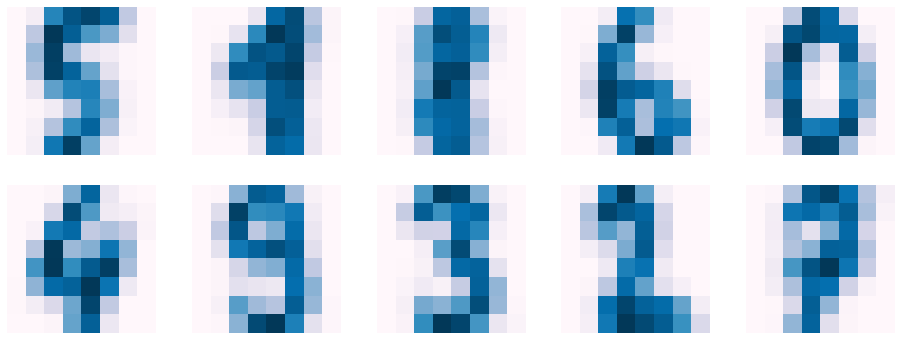

In [19]:
plt.figure(figsize=(16, 6))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    ax.set_axis_off()
    ax.imshow(km.cluster_centers_[i].reshape([8,8]), cmap='PuBu');

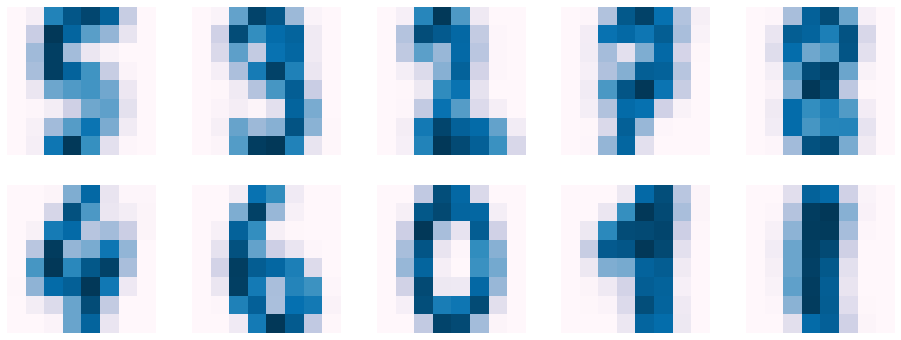

In [20]:
from sklearn.neighbors import NearestCentroid
clf = NearestCentroid()
clf.fit(X, hierarchical_labels)

plt.figure(figsize=(16, 6))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    ax.set_axis_off()
    ax.imshow(clf.centroids_[i].reshape([8,8]), cmap='PuBu');

In a situation where the true number of classes is unknown, we can select it by maximazing some metric.

When we can set some distance function between our observations, we can consider the `silhouette` distance as a function of measuring the quality of the clustering. Let's show how it is calculated:

Let $X$ – set of observations, $M \subset X$ – one of the clusters obtained as a result of clustering process, $\rho$ – some metric on $X$. Let's choose one observation $x \in M$. Denote $a(x)$ as the average distance from $x$ to  $x'$ points from the same cluster:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Denote $b(x)$ as minimun of average distances from $x$ to $x''$ from some other cluster $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

The silhouette is difference between a(x) and b(x), normalized to $[-1, \, 1]$ and averaged over all observations:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

The implementation of this metric in the `scikit-learn` is the `silhouette_score` function from the `metrics` submidule.

**(0.75 point)** For each $K$ between 2 and 20 inclusive, partition of the array $X$ into $K$ clusters using both methods. Calculate the silhouette score and visualize it for both methods on the same plot ($K$ on the $x$ axis and silhouette score on the $y$ axis). Sign the axes and make a legend.

In [21]:
from sklearn.metrics import silhouette_score, v_measure_score

In [22]:
K = range(2, 21)
sil_score_km, sil_score_agg = [], []

for i in K:
    km = KMeans(n_clusters=i)
    km.fit(X)
    kmeans_labels = km.predict(X)
    sil_score_km.append(silhouette_score(X, kmeans_labels))
    
    agg_cl = AgglomerativeClustering(n_clusters=i)
    hierarchical_labels = agg_cl.fit_predict(X)
    sil_score_agg.append(silhouette_score(X, hierarchical_labels))

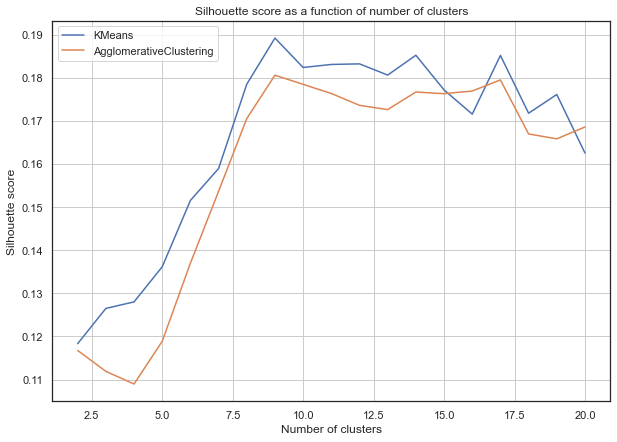

In [23]:
plt.figure(figsize=(10, 7))
plt.plot(K, sil_score_km, label='KMeans')
plt.plot(K, sil_score_agg, color='C1', label='AgglomerativeClustering')
plt.title("Silhouette score as a function of number of clusters")
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.grid(True)
plt.legend();        

In [24]:
sil_km_full = np.max(sil_score_km)
sil_agg_full = np.max(sil_score_agg)
print(f'The best silhouette score for KMeans {sil_km_full}')
print(f'The best silhouette score for AgglomerativeClustering {sil_agg_full}')

The best silhouette score for KMeans 0.18923512342916698
The best silhouette score for AgglomerativeClustering 0.18061975703867697


In [25]:
print(f'The best silhouette score for KMeans with {K[np.argmax(sil_score_km)]} number of clusters.')
print(f'The best silhouette score for AgglomerativeClustering with {K[np.argmax(sil_score_agg)]} number of clusters.')                                      

The best silhouette score for KMeans with 9 number of clusters.
The best silhouette score for AgglomerativeClustering with 9 number of clusters.


I think we have the best silhouette score with number of clusters = 9, because some digits are very similar when handwritten. So, algoritm work better when put it to the one cluster.

When we know the true clustering labels, the clustering result can be compared to them using measures such as `homogeneity`, `completeness` and their harmonic mean - $V$-score. The definitions of these quantities are rather bulky and are based on the [entropy of the probability distribution](https://ru.wikipedia.org/wiki/Информационная_энтропия). Details are given in [this article](http://aclweb.org/anthology/D/D07/D07-1043.pdf). In practice, it's enough to know that `homogeneity`, `completeness` and $V$-score are in the range from 0 and 1, and the more, the better.

Since we know what digit each image is (`y` array), we can compare the clustering results to it using the measures listed above.

**(0.5 points)** Repeat the previous task using $V$-measure instead of silhouette.

In [26]:
K = range(2, 21)
v_measure_km, v_measure_agg = [], []

for i in K:
    km = KMeans(n_clusters=i)
    km.fit(X)
    kmeans_labels = km.predict(X)
    v_measure_km.append(v_measure_score(y, kmeans_labels))
    
    agg_cl = AgglomerativeClustering(n_clusters=i)
    hierarchical_labels = agg_cl.fit_predict(X)
    v_measure_agg.append(v_measure_score(y, hierarchical_labels))

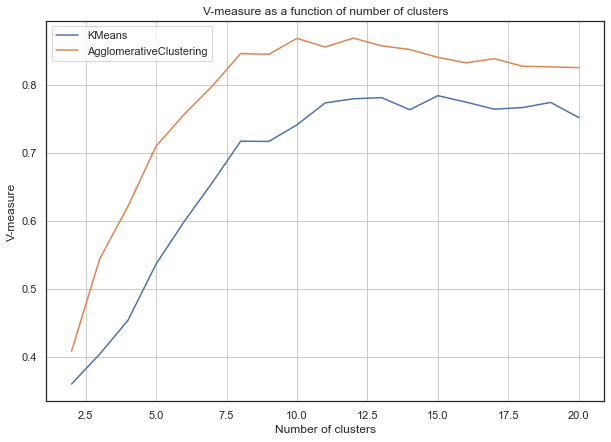

In [27]:
plt.figure(figsize=(10, 7))
plt.plot(K, v_measure_km, label='KMeans')
plt.plot(K, v_measure_agg, color='C1', label='AgglomerativeClustering')
plt.title("V-measure as a function of number of clusters")
plt.xlabel('Number of clusters')
plt.ylabel('V-measure')
plt.grid(True)
plt.legend();    

In [28]:
v_km_full = np.max(v_measure_km)
v_agg_full = np.max(v_measure_agg)
print(f'The best V-measure for KMeans {v_km_full}')
print(f'The best V-measure for AgglomerativeClustering {v_agg_full}')

The best V-measure for KMeans 0.7838920402098346
The best V-measure for AgglomerativeClustering 0.86854875186737


In [29]:
print(f'The best V-measure for KMeans with {K[np.argmax(v_measure_km)]} number of clusters.')
print(f'The best V-measure for AgglomerativeClustering with {K[np.argmax(v_measure_agg)]} number of clusters.')                                      

The best V-measure for KMeans with 15 number of clusters.
The best V-measure for AgglomerativeClustering with 12 number of clusters.


But, when we look at V-measure (which perform the best combination of homogeneity and completeness) it seems better to recieve more clusters, even more that they were performed in dataset. 

## 3. Feature space dimensionality reduction

In some cases, especially when there are a large number of features, when not all of them are informative, and some of them are correlated, it can be useful to reduce the dimension of the feature space. This mean that instead of $d$ original features, we will go to $d'\ll d$ new ones. And if earlier our data were presented in the form of an $n×d$ matrix, then it will presented as a $n×d'$.

There are two popular dimensionality reduction approaches:
- select new features from existing features;
- extract the new features by transforming old ones, for example, by making $d'$ different linear combinations of columns of an $n×d$ matrix.

One widely used dimensionality reduction technique is the Singular Value Decomposition (SVD). This method allows you to construct any number $d'\leq d$ of new features in such a way that they are the most informative (in some sense).

The `scikit-learn` module has several implementations of singular value decomposition. We will use the `TruncatedSVD` class from the `decomposition` submodule.

**Note:** The singular value decomposition of the matrix $M$ is usually written as $M=U \Sigma V^{*}$. `TruncatedSVD`, in turn, returns only the $d'$ first columns of the matrix $U$.

**(0.75 point)** Perform a singular value decomposition of the $X$ matrix, leaving 2, 5, 10, 20 features. In each case, perform hierarchical clustering and $K$-Means clustering (take the number of clusters equal to 10). Calculate the silhouette and $V$-score and compare them to corresponding values obtained from the original data.

**Note**: It is not valid to compare the silhouette calculated with different metrics. Even if we use the same metric function when calculating the distance between points in the data, after applying dimensionality reduction or other data transformations, we will (not always) get different silhouette scores. Therefore, after training the clustering algorithm, to compare the result of clustering, you need to calculate the silhouette on the original data.

In [30]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

In [31]:
st_sc = StandardScaler()
X_sc = st_sc.fit_transform(X)

In [32]:
n_features = [2, 5, 10, 20]
sil_score_km, sil_score_agg = [], []
v_measure_km, v_measure_agg = [], []

for n_f in n_features:
    svd = TruncatedSVD(n_components=n_f, random_state=42)
    X_new = svd.fit_transform(X_sc)
    
    km = KMeans(n_clusters=10)
    km.fit(X_new)
    kmeans_labels = km.predict(X_new)
    sil_score_km.append(silhouette_score(X, kmeans_labels))
    v_measure_km.append(v_measure_score(y, kmeans_labels))
    
    agg_cl = AgglomerativeClustering(n_clusters=10)
    hierarchical_labels = agg_cl.fit_predict(X_new)
    sil_score_agg.append(silhouette_score(X, hierarchical_labels))
    v_measure_agg.append(v_measure_score(y, hierarchical_labels))

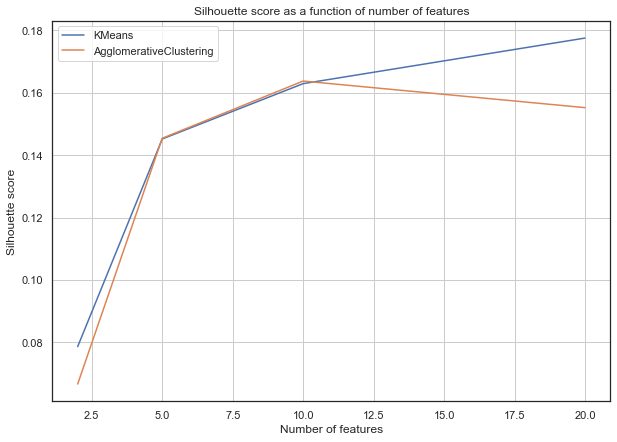

In [33]:
plt.figure(figsize=(10, 7))
plt.plot(n_features, sil_score_km, label='KMeans')
plt.plot(n_features, sil_score_agg, color='C1', label='AgglomerativeClustering')
plt.title("Silhouette score as a function of number of features")
plt.xlabel('Number of features')
plt.ylabel('Silhouette score')
plt.grid(True)
plt.legend();        

In [34]:
sil_km_svd = np.max(sil_score_km)
sil_agg_svd = np.max(sil_score_agg)
print(f'The best silhouette score for KMeans {sil_km_svd}')
print(f'The best silhouette score for AgglomerativeClustering {sil_agg_svd}')

The best silhouette score for KMeans 0.1775369446363719
The best silhouette score for AgglomerativeClustering 0.16376731699875294


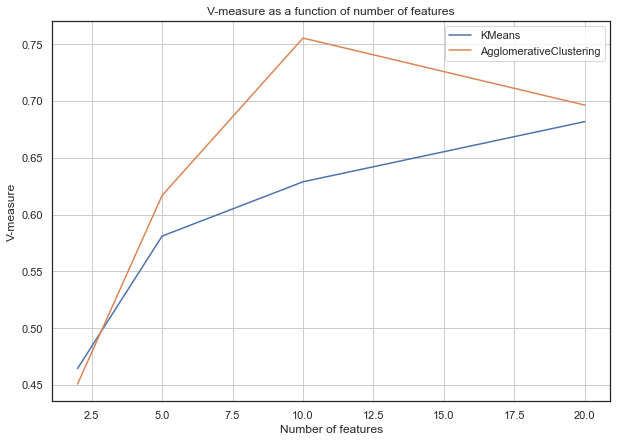

In [35]:
plt.figure(figsize=(10, 7))
plt.plot(n_features, v_measure_km, label='KMeans')
plt.plot(n_features, v_measure_agg, color='C1', label='AgglomerativeClustering')
plt.title("V-measure as a function of number of features")
plt.xlabel('Number of features')
plt.ylabel('V-measure')
plt.grid(True)
plt.legend();  

In [36]:
v_km_svd = np.max(v_measure_km)
v_agg_svd = np.max(v_measure_agg)
print(f'The best V-measure for KMeans {v_km_svd}')
print(f'The best V-measure for AgglomerativeClustering {v_agg_svd}')

The best V-measure for KMeans 0.681809927767273
The best V-measure for AgglomerativeClustering 0.7553196558050427


Both silhouette score and V-measure in case of Singular Value Decomposition is a little worse.

In case of KMeans algoritm the best number of features is 20. And seems like it is increasing further.

In case of AgglomerativeClustering - 10.

Another popular dimensionality reduction approach that is useful for working with images is t-distributed stochastic neighbor embeddings, abbreviated `tSNE`. Unlike singular value decomposition, this it is non-linear transformation. It's main idea is to map points from a space of dimension `d` to another space of dimension 2 or 3 in such a way that the distances between points are mostly preserved. Mathematical details can be found, for example, [here](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).

The implementation of `tSNE` in the `scikit-learn` library is the `TSNE` class in the `manifold` submodule.

**Note:** In recent years [UMAP](https://github.com/lmcinnes/umap) is often used istead of `tSNE`. It is a faster algorithm with similar properties. We don't ask you to use `UMAP` because it requires you to install another dependency, the `umap-learn` library. Those who wish can perform the following task using `UMAP`.

**(0.5 points)** Perform a tSNE-transform of the `X` matrix, leaving 2 features. Visualize the obtained data in the form of a scatter plot form: the first feature on the horizontal axis, and the second one the vertical axis. Color the points according to the digits they belong to.

- The `c` parameter in the plt.scatter function is responsible for the color of the points. Pass the true labels to it.

In [37]:
from sklearn.manifold import TSNE

In [38]:
X_new = TSNE(n_components=2).fit_transform(X)

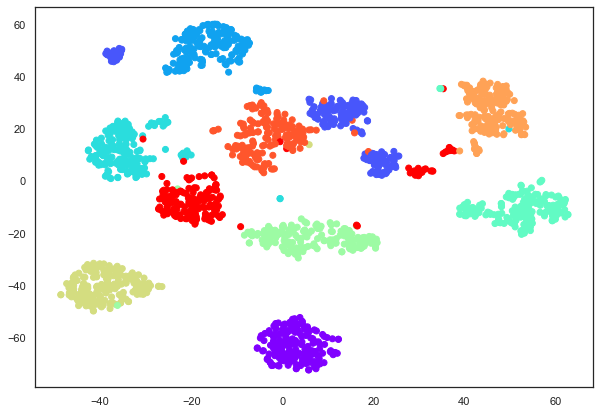

In [39]:
plt.figure(figsize=(10, 7))
plt.scatter(X_new[:, 0], X_new[:, 1], c=y, cmap='rainbow');

We can surely say that is a good visualized picture with separated clusters. But for some samples it worked worse, for example some samples of red cluster are in the wrong place.

**(0.5 points)** From the data transformed using the tSNE, perform hierarchical clustering and $K$-means clustering (take the number of clusters equal to 10). Calculate the silhouette and the $V$-score and compare them to corresponding values obtained from the original data.

In [40]:
km = KMeans(n_clusters=10)
km.fit(X_new)
kmeans_labels = km.predict(X_new)
sil_km_tsne = silhouette_score(X, kmeans_labels)
v_km_tsne = v_measure_score(y, kmeans_labels)
print(f'Silhouette score for KMeans with 2 features: {sil_km_tsne}')
print(f'V-score for KMeans with 2 features: {v_km_tsne}')
print()

agg_cl = AgglomerativeClustering(n_clusters=10)
hierarchical_labels = agg_cl.fit_predict(X_new)
sil_agg_tsne = silhouette_score(X, hierarchical_labels)
v_agg_tsne = v_measure_score(y, hierarchical_labels)
print(f'Silhouette score for AgglomerativeClustering with 2 features: {sil_agg_tsne}')
print(f'V-score for AgglomerativeClustering with 2 features: {v_agg_tsne}')

Silhouette score for KMeans with 2 features: 0.16961823560946793
V-score for KMeans with 2 features: 0.8958458861537021

Silhouette score for AgglomerativeClustering with 2 features: 0.17159988171756102
V-score for AgglomerativeClustering with 2 features: 0.8812239529044313


Values of silhouette score are less than without reducing number of features or TruncatedSVD.

But values of V-score are much better (bigger) now.

**(0.25 points)** Choose the best partition (in terms of silhouette or $V$-score) and visualize the centers of clusters with images. Did you managed to make each digit correspond to one center of the cluster?

We will choose the result with the best V-score. It was two last methods with tSNE with 2 features. In case of AgglomerativeClustering v-score is a little less than v_score KMeans, but its silhouette is better more. So we will choose it.

It is AgglomerativeClustering with tSNE (2 features), which was the last.

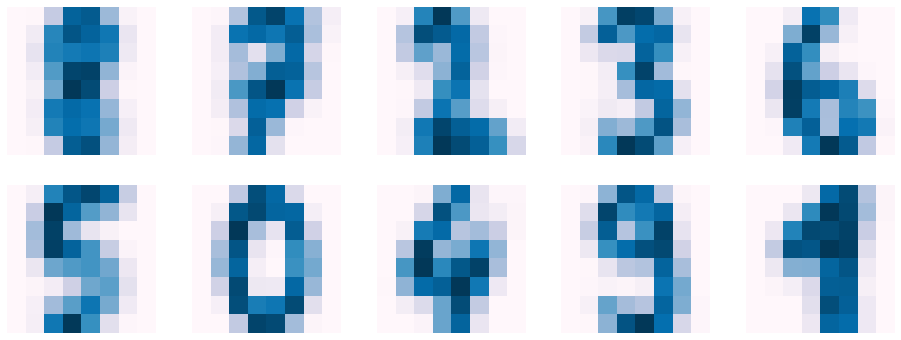

In [41]:
clf = NearestCentroid()
clf.fit(X, hierarchical_labels)

plt.figure(figsize=(16, 6))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    ax.set_axis_off()
    ax.imshow(clf.centroids_[i].reshape([8,8]), cmap='PuBu');

Compared to the first center of the clusters visualization (at the begining of the homework) now the picture is clearer. All digits are clearly viewed.

## 4. Results and bonus part

Write in free form what conclusions you made after completing this assignment. Answer the following questions:

**(0.5 points)** Which algorithm gives more meaningful results - hierarchical clustering or $K$- means clustering. Does it depend on the algorithm settings or on the quality evaluation method?

In [42]:
datas = np.array([[sil_km_full, sil_km_svd, sil_km_tsne, sil_agg_full, sil_agg_svd, sil_agg_tsne], \
         [v_km_full, v_km_svd, v_km_tsne, v_agg_full, v_agg_svd, v_agg_tsne]])
df = pd.DataFrame(datas, index=['silhouette', 'v-score'], columns=['KMeans', 'KMeans with SVD',  \
                                                                   'KMeans with TSNE', 'AgglomerativeClustering', \
                                                                  'AgglomerativeClustering with SVD', \
                                                                  'AgglomerativeClustering with TSNE'])
df

,KMeans,KMeans with SVD,KMeans with TSNE,AgglomerativeClustering,AgglomerativeClustering with SVD,AgglomerativeClustering with TSNE
silhouette,0.189235,0.177537,0.169618,0.180620,0.163767,0.171600
v-score,0.783892,0.681810,0.895846,0.868549,0.755320,0.881224


Which algorithm is the best option on this dataset depends on both the quality evaluation method and the algorithm settings. 

If we look at the silhouette as a quality messure - the best choise will be to use KMeans algoritm with better parametrs for it (max_iter and n_init).

If the messure of quality is v-score - surely, the best choise will be also KMeans but using tSNE with 2 features..

**(0.5 points)** Imagine the situation where after hierarchical clustering, you need to cluster new data in the same way without retraining the model. Suggest a method how you will do it and how you will measure the quality of clustering of new data.

For clustering new data in this case we can calculate the centers of clusters manually or using NearestCentroid() from sklearn. And then, cluster new data.

Supposing that we don't have true labels of data it will be better to use silhouette as a quality messure. 

**(0.5 points)** Does dimensionality reduction improve clustering results?

It depends on the chosen method, quality messure and datasets. In our case, If we use silhouette as quality messure for both KMeans and Agglomerative Clustering there is no improving results with dimensionality reduction.

But, if we use v-score - both algorithms are working better with TSNE dimensionality reduction.

**(0.5 points)** How to evaluate the quality of dimensional reduction? Suggest at least 2 options.

1. We can see on correlations between features before dimensional reduction. This way we can see how many linear dependencies there are in the dataset. So, after the dimensional reduction correlations should be more less or not to be at all. We can use the value of desreasing coreelations as a quality measure.

2. If the number of features after dimensional reduction is equal to 2 or 3 we can plot it. If we could clearly view different clusters on the plot - the method probably had worked well.

3. We can use the result quality messure before applying clustering algoritm (KMeans,  Agglomerative Clustering, etc...) with and without dimensional reduction - if chosen metrics become better than it probably may mean that dimensional reduction was useful in this case.

**(Bonus 2 points)** Load the [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist) dataset. You can also do it with `scikit-learn` as explained [here](https://stackoverflow.com/a/60450028). Explore the data and try to cluster it using different approaches. Compare results of these approaches using the silhouette and the $V$-score.

In [43]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [44]:
X

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


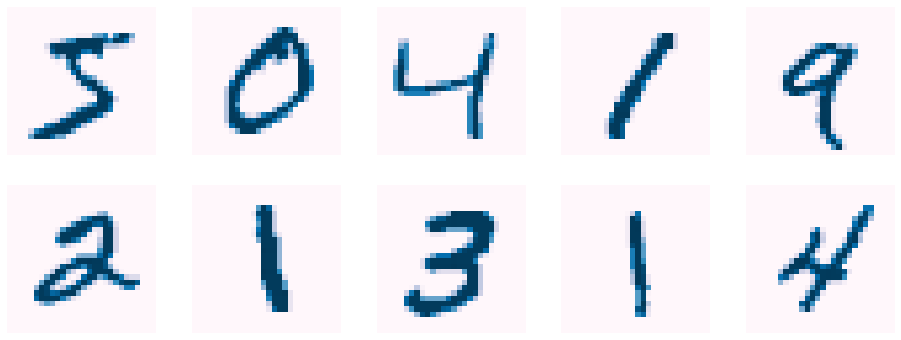

In [45]:
plt.figure(figsize=(16, 6))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    ax.set_axis_off()
    ax.imshow(X.values[i,:].reshape([28,28]), cmap='PuBu');

In [46]:
y

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

First, let's cluster the data using **KMeans**.

In [47]:
km = KMeans(n_clusters=10)
km.fit(X)
kmeans_labels = km.predict(X)
sil_km_full = silhouette_score(X, kmeans_labels)
v_km_full = v_measure_score(y, kmeans_labels)

In [48]:
print(f'Silhouette score for KMeans: {sil_km_full}')
print(f'V score for KMeans: {v_km_full}')

Silhouette score for KMeans: 0.0586915389505002
V score for KMeans: 0.49972829981134365


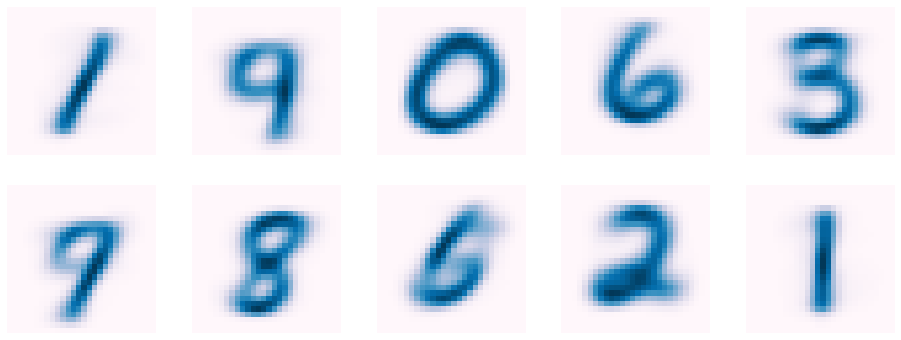

In [49]:
plt.figure(figsize=(16, 6))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    ax.set_axis_off()
    ax.imshow(km.cluster_centers_[i].reshape([28,28]), cmap='PuBu');

Some digits are very clearly view. But, for example 5, 7, 4 it's difficult to recognize.

Now, let's cluster the data using **Agglomerative Clustering**.

In [50]:
#agg_cl = AgglomerativeClustering(n_clusters=10)
#hierarchical_labels = agg_cl.fit_predict(X)
#sil_agg_full = silhouette_score(X, hierarchical_labels)
#v_agg_full = v_measure_score(y, hierarchical_labels)

#print(f'Silhouette score for AgglomerativeClustering with 2 features: {sil_agg_full}')
#print(f'V score for AgglomerativeClustering with 2 features: {v_agg_full}')

It takes a huge amount of time to run a code with Agglomerative Clustering. I think the reason is the dataset size (70000 rows × 784 columns). Let's try to use dimensional reduction and then try again.

We will decrease number of features, first with **TruncatedSVD**.

In [51]:
st_sc = StandardScaler()
X_sc = st_sc.fit_transform(X)

In [52]:
n_features = [2, 5, 10, 20]
sil_score_km, sil_score_agg = [], []
v_measure_km, v_measure_agg = [], []

for n_f in n_features:
    svd = TruncatedSVD(n_components=n_f, random_state=42)
    X_new = svd.fit_transform(X_sc)
    
    km = KMeans(n_clusters=10)
    km.fit(X_new)
    kmeans_labels = km.predict(X_new)
    sil_score_km.append(silhouette_score(X, kmeans_labels))
    v_measure_km.append(v_measure_score(y, kmeans_labels))
    
    agg_cl = AgglomerativeClustering(n_clusters=10)
    hierarchical_labels = agg_cl.fit_predict(X_new)
    sil_score_agg.append(silhouette_score(X, hierarchical_labels))
    v_measure_agg.append(v_measure_score(y, hierarchical_labels))

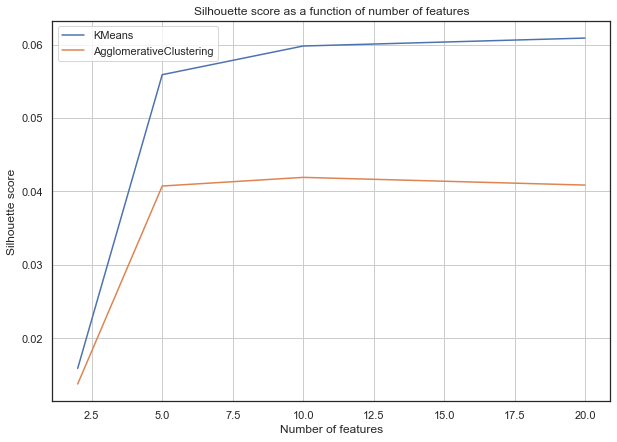

In [53]:
plt.figure(figsize=(10, 7))
plt.plot(n_features, sil_score_km, label='KMeans')
plt.plot(n_features, sil_score_agg, color='C1', label='AgglomerativeClustering')
plt.title("Silhouette score as a function of number of features")
plt.xlabel('Number of features')
plt.ylabel('Silhouette score')
plt.grid(True)
plt.legend();    

In [54]:
sil_km_svd = np.max(sil_score_km)
sil_agg_svd = np.max(sil_score_agg)
print(f'The best silhouette score for KMeans {sil_km_svd}')
print(f'The best silhouette score for AgglomerativeClustering {sil_agg_svd}')

The best silhouette score for KMeans 0.06090806451039004
The best silhouette score for AgglomerativeClustering 0.04191439567756047


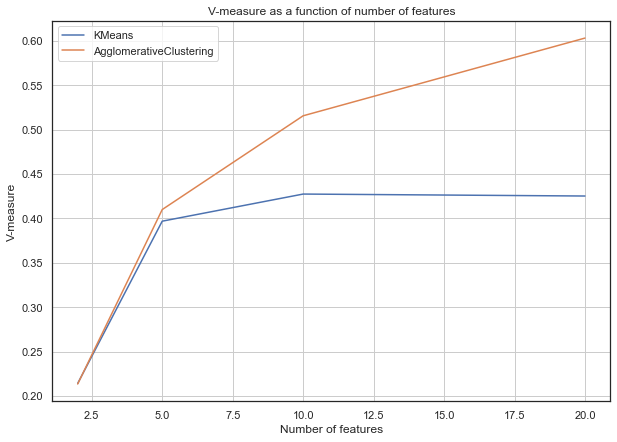

In [55]:
plt.figure(figsize=(10, 7))
plt.plot(n_features, v_measure_km, label='KMeans')
plt.plot(n_features, v_measure_agg, color='C1', label='AgglomerativeClustering')
plt.title("V-measure as a function of number of features")
plt.xlabel('Number of features')
plt.ylabel('V-measure')
plt.grid(True)
plt.legend();  

In [56]:
v_km_svd = np.max(v_measure_km)
v_agg_svd = np.max(v_measure_agg)
print(f'The best V-measure for KMeans {v_km_svd}')
print(f'The best V-measure for AgglomerativeClustering {v_agg_svd}')

The best V-measure for KMeans 0.42743533979896325
The best V-measure for AgglomerativeClustering 0.603179002524112


Seems like increasing number of features doesn't make KMeans work much better. 

Now we will use **TSNE**.

In [57]:
sil_score_km, sil_score_agg = [], []
v_measure_km, v_measure_agg = [], []

for n_f in [2, 3]:
    X_new = TSNE(n_components=n_f, random_state=42).fit_transform(X)
    
    km = KMeans(n_clusters=10)
    km.fit(X_new)
    kmeans_labels = km.predict(X_new)
    sil_score_km.append(silhouette_score(X, kmeans_labels))
    v_measure_km.append(v_measure_score(y, kmeans_labels))
    
    agg_cl = AgglomerativeClustering(n_clusters=10)
    hierarchical_labels = agg_cl.fit_predict(X_new)
    sil_score_agg.append(silhouette_score(X, hierarchical_labels))
    v_measure_agg.append(v_measure_score(y, hierarchical_labels))

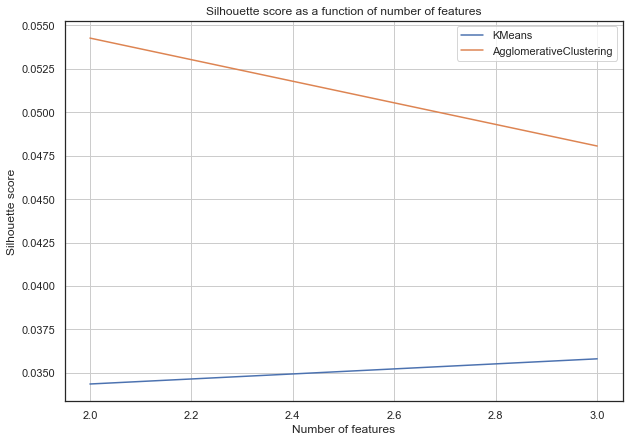

In [58]:
plt.figure(figsize=(10, 7))
plt.plot([2,3], sil_score_km, label='KMeans')
plt.plot([2,3], sil_score_agg, color='C1', label='AgglomerativeClustering')
plt.title("Silhouette score as a function of number of features")
plt.xlabel('Number of features')
plt.ylabel('Silhouette score')
plt.grid(True)
plt.legend();    

In [59]:
sil_km_svd = np.max(sil_score_km)
sil_agg_svd = np.max(sil_score_agg)
print(f'The best silhouette score for KMeans {sil_km_svd}')
print(f'The best silhouette score for AgglomerativeClustering {sil_agg_svd}')

The best silhouette score for KMeans 0.03581137413827366
The best silhouette score for AgglomerativeClustering 0.05426739142189555


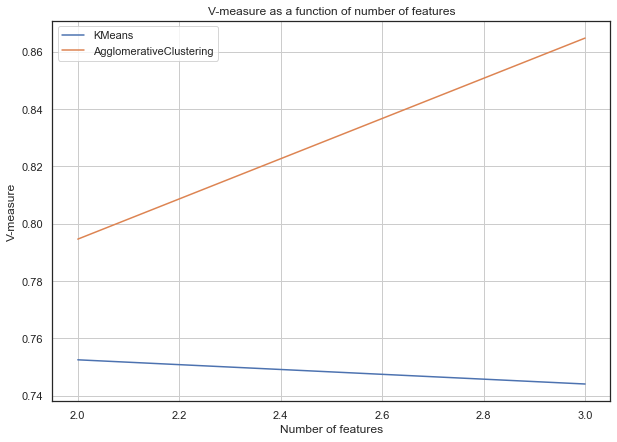

In [60]:
plt.figure(figsize=(10, 7))
plt.plot([2,3], v_measure_km, label='KMeans')
plt.plot([2,3], v_measure_agg, color='C1', label='AgglomerativeClustering')
plt.title("V-measure as a function of number of features")
plt.xlabel('Number of features')
plt.ylabel('V-measure')
plt.grid(True)
plt.legend();  

In [61]:
v_km_svd = np.max(v_measure_km)
v_agg_svd = np.max(v_measure_agg)
print(f'The best V-measure for KMeans {v_km_svd}')
print(f'The best V-measure for AgglomerativeClustering {v_agg_svd}')

The best V-measure for KMeans 0.7525268353340322
The best V-measure for AgglomerativeClustering 0.8648190268644292


In [62]:
datas = np.array([[sil_km_full, sil_km_svd, sil_km_tsne, None, sil_agg_svd, sil_agg_tsne], \
         [v_km_full, v_km_svd, v_km_tsne, None, v_agg_svd, v_agg_tsne]])
df = pd.DataFrame(datas, index=['silhouette', 'v-score'], columns=['KMeans', 'KMeans with SVD',  \
                                                                   'KMeans with TSNE', 'AgglomerativeClustering', \
                                                                  'AgglomerativeClustering with SVD', \
                                                                  'AgglomerativeClustering with TSNE'])
df

,KMeans,KMeans with SVD,KMeans with TSNE,AgglomerativeClustering,AgglomerativeClustering with SVD,AgglomerativeClustering with TSNE
silhouette,0.058692,0.035811,0.169618,None,0.054267,0.1716
v-score,0.499728,0.752527,0.895846,None,0.864819,0.881224


Better silhouette score is with Agglomerative Clustering with TSNE dimensional reduction with number of features = 2, but better v-score is with KMeans with TSNE dimensional reduction with number of features = 3. Let's choose silhouette as a quality messure and select Agglomerative Clustering with TSNE dimensional reduction with 2 number od features.

We will train final model and vizualize cluster centers.

In [64]:
X_new = TSNE(n_components=2, random_state=42).fit_transform(X)

agg_cl = AgglomerativeClustering(n_clusters=10)
hierarchical_labels = agg_cl.fit_predict(X_new)

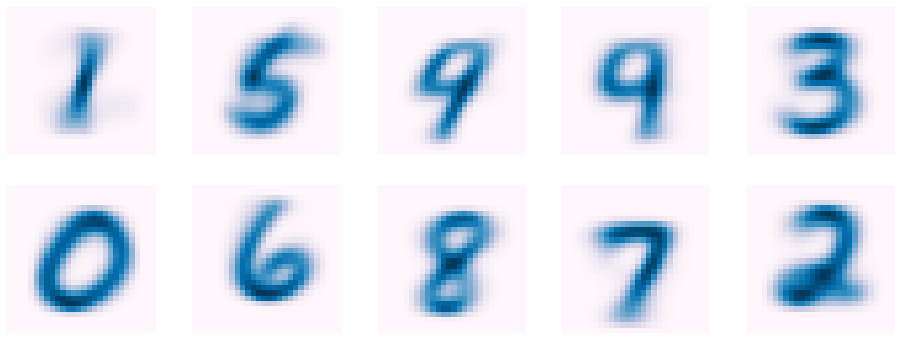

In [65]:
clf = NearestCentroid()
clf.fit(X, hierarchical_labels)

plt.figure(figsize=(16, 6))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    ax.set_axis_off()
    ax.imshow(clf.centroids_[i].reshape([28,28]), cmap='PuBu');

Numbers 4 and 9 have very similar results. The rest is very clearly viewed.